# Homework 2 - data transformation & dimensionality reduction (deadline 2. 1. 2020)

In short, the main task is to play with transformations and dimensionality reduction to obtain the best results for the linear regression model predicting house sale prices.
  
> The instructions are not given in detail: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do:

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (data.csv, data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
  1. Split the dataset into a train & test part exactly as we did in the tutorial. Use the test part for evaluation of the influence of further steps.
  1. Transform features appropriately & prepare new ones - focus on the increase in the performance of the model (possibly in combination with further steps).
  1. Try to find some suitable subset of features - first without the use of PCA.
  1. Use PCA (principal component analysis) to reduce the dimensionality. Discuss the influence of the number of principal components.
  1. Compare the results of previous steps on the test part of the dataset.
  
Give comments on each step of your solution, with short explanations of your choices.

  
**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

# Introduction
First I am going to load and explore the dataset and import important packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats

In [2]:
data = pd.read_csv("data.csv", index_col=0)
# data.info()
# data.head()

In [3]:
df = data.copy()

Let us also convert all non-indicator values to float64 - which would be useful later.

In [4]:
df[df.select_dtypes(['float16', 'float64', 'int64']).columns] = df[df.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')
df.dtypes.value_counts()

object     43
float64    37
dtype: int64

## Missing data treatment
First I am going to take a look on continuous features (since dummies are going to take care of missing values)

In [5]:
df.select_dtypes(exclude=['object']).isna().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

If Lot Frontage does not exist in the house, this entry is 0.

In [6]:
df.LotFrontage = df.LotFrontage.fillna(0)

In [7]:
# sns.distplot(df.MasVnrArea.dropna())
df[df.MasVnrArea.isna()].MasVnrType

Id
235     NaN
530     NaN
651     NaN
937     NaN
974     NaN
978     NaN
1244    NaN
1279    NaN
Name: MasVnrType, dtype: object

In [8]:
df.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

Same with Masonry Veneer area.

In [9]:
df.MasVnrType = df.MasVnrType.fillna('None')
df.MasVnrArea = df.MasVnrArea.fillna(0)

In [10]:
# well, I dont like this approach, since 0 is the year of our Salvator :) Since the garage is missing, I would ignore this wrongly assigned missing values
df.GarageYrBlt = df.GarageYrBlt.fillna(0)

# Addition of columns

Let us create new features as square roots of Area features - i.e. so they correspond to diameters of circles having the same area.

We also add indicators of zero values (usually missings) there

In [11]:
for column in df.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])

print('Shape of the data:', df.shape)

Shape of the data: (1460, 108)


# Converting categorical features

In [12]:
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']) \
    .apply(lambda x: x.str.lower()) \
    .apply(pd.Series.astype, dtype='category')
df = pd.get_dummies(df, dummy_na=True)

# Constant features removal
They are not beneficial for the model.

In [13]:
display(df.shape)
df = df.loc[:, (df != df.iloc[0]).any()]
df.shape

(1460, 360)

(1460, 329)

In [14]:
df.isna().sum()[df.isna().sum() != 0]

Series([], dtype: int64)

# Transformation of the target variable
It might be beneficial to transform the target variable as well. You should see the impact in the Homework.

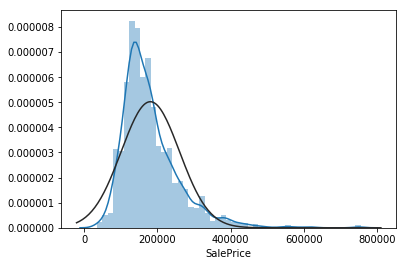

In [15]:
sns.distplot(df.SalePrice, fit=stats.norm)

Distribution of the target feature is a bit skewed. Let's see, how it will look like after applying logarithm

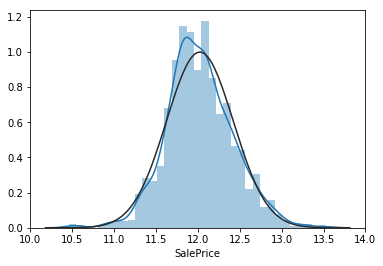

In [16]:
sns.distplot(np.log(df.SalePrice), fit=stats.norm)

This is what "actually happens", when computing RMSLE.

# Defining the model

In [17]:
from sklearn.metrics import mean_squared_log_error

In [18]:
def linreg(train, validate, plot = False, train_error = True, verbose=True, msle=mean_squared_log_error):
    
    # Data prepare
    X = train.drop(columns=['SalePrice'])
    y = train.SalePrice
    Xv = validate.drop(columns=['SalePrice'])
    yv = validate.SalePrice
    
    # Linear Regression train
    clf = LinearRegression()
    clf.fit(X, y) 
    
    if verbose:
        if any(x < 0 for x in yv) or any(x < 0 for x in clf.predict(Xv)):
            print("prediction less than zero")
        if any(x < 0 for x in y) or any(x < 0 for x in clf.predict(X)):
            print("prediction less than zero")

    val_err = np.sqrt(msle(clf.predict(Xv), yv))
    train_err = np.sqrt(msle(clf.predict(X), y))
    
    # Print RMSLE
    if verbose:
        print(f'LinReg RMSLE valid: {val_err}')
        if train_error:
            print(f'LinReg RMSLE train: {train_err}')
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))
    
    return val_err, train_err

## RMSLE problems
I accounted errors, when computing RMSLE, if prediction contains negative values. 

I assume, price cannot be negative, so I first replace all negative values with zero.

There are a few discussions about RMSLE:

* [here](https://www.researchgate.net/post/How_to_handle_negative_values_in_log_transformations_in_a_regression_analysis2) they suggest add a constant to the target
* [here](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064) they are arguing about usefulness of this metric.

Since I am not sure, what to do, I will still use RMSLE as defined [here](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error) but with non-negative values.

In [19]:
def my_msle(y, y0):
    y = np.array(y)
    y[y < 0] = 0
    return np.mean(np.square(np.log1p(y) - np.log1p(y0)))

print(np.sqrt(my_msle([-1,2,1], [1,1,1])))
print(np.sqrt(mean_squared_log_error( [0,2,1], [1,1,1])))

0.4636287911002964
0.4636287911002964


# Splitting the dataset
into train, validation subset. Same as in tutorial.

In [20]:
dt, dv = train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dv = dv.copy()
dv.shape, dt.shape

((365, 329), (1095, 329))

## Linear regression on pure data

In [21]:
linreg(dt, dv)

LinReg RMSLE valid: 0.167357599945378
LinReg RMSLE train: 0.09821406780159678


(0.167357599945378, 0.09821406780159678)

In [22]:
linreg(dt, dv, msle=my_msle)

LinReg RMSLE valid: 0.167357599945378
LinReg RMSLE train: 0.09821406780159678


(0.167357599945378, 0.09821406780159678)

# Feature selection
let's find features, which may not help us.

## Variance approach
These features can be detected as a variables with very **low variance**. It means that they are almost constant. 

First, let's scale our data with standard scaler (and minmax scaler):

In [23]:
from sklearn import preprocessing

# Standardization
standard_scaler = preprocessing.StandardScaler()
# Min-max normalization
minmax_scaler = preprocessing.MinMaxScaler()

# we rescale only numeric values - not indicators
columns = dt.select_dtypes(include=['float64']).columns 
columns = columns.drop('SalePrice', errors = 'ignore')
print('Columns to be normalized: ', list(columns))

# Prepare values for the transformation
standard_scaler.fit(dt[columns])
minmax_scaler.fit(dt[columns])

# Transform of both train and validation
# Standardization
dt_s = dt.copy()
dv_s = dv.copy()
dt_s[columns] = standard_scaler.transform(dt[columns])
dv_s[columns] = standard_scaler.transform(dv[columns])
# MinMax
dt_m = dt.copy()
dv_m = dv.copy()
dt_m[columns] = minmax_scaler.transform(dt[columns])
dv_m[columns] = minmax_scaler.transform(dv[columns])

Columns to be normalized:  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SqrtLotArea', 'SqrtMasVnrArea', 'SqrtBsmtFinSF1', 'SqrtBsmtFinSF2', 'SqrtBsmtUnfSF', 'SqrtTotalBsmtSF', 'Sqrt1stFlrSF', 'Sqrt2ndFlrSF', 'SqrtLowQualFinSF', 'SqrtGrLivArea', 'SqrtGarageArea', 'SqrtWoodDeckSF', 'SqrtOpenPorchSF', 'SqrtPoolArea']


In [24]:
treshold_var = 0.001
columns_to_remove = list(dt_s.columns[dt_s.var() < treshold_var])
len(columns_to_remove)

23

In [25]:
dt[columns_to_remove].var().nsmallest(10)

Utilities_allpub       0.000000
Utilities_nosewa       0.000000
Condition2_rrnn        0.000000
RoofMatl_metal         0.000000
Electrical_nan         0.000000
Condition2_rran        0.000913
RoofMatl_membran       0.000913
Exterior1st_asphshn    0.000913
RoofMatl_clytile       0.000913
Exterior2nd_other      0.000913
dtype: float64

One must be careful, what kind of data to use, scalinf can make the variance of non-inicator features equaling 1.

Now, here is a wild guess of RMSLE after removing 23 low-variance features:

In [26]:
linreg(dt.drop(columns=columns_to_remove), dv.drop(columns=columns_to_remove), msle=my_msle)

LinReg RMSLE valid: 0.1531283323030124
LinReg RMSLE train: 0.0985559360557743


(0.1531283323030124, 0.0985559360557743)

Thankfully, having treshold set to .001, LinReg did better.

Be aware, that I was computing the RMSLE on validation data. Therefore this "wild guess" can be unachievable in real life.

Now let's find the best treshold for train data:

In [27]:
space = np.linspace(0.1, 0.00001, 100)
test_errs = pd.Series(index=space)
for t in space:
#     split train set into train & test again, so that validation is unknown.
    dtr, dts = train_test_split(dt_s, test_size=0.10, random_state=17)
    columns_to_remove = list(dtr.columns[dtr.var() < t])
    verr, terr = linreg(dtr.drop(columns=columns_to_remove), dts.drop(columns=columns_to_remove), verbose=False, msle=my_msle)
    test_errs[t] = verr
best_treshold = test_errs.idxmin()
print("best_treshold: ", best_treshold)

best_treshold:  0.034350000000000006


[Text(0, 0.5, 'test set RMSLE'), Text(0.5, 0, 'variance treshold')]

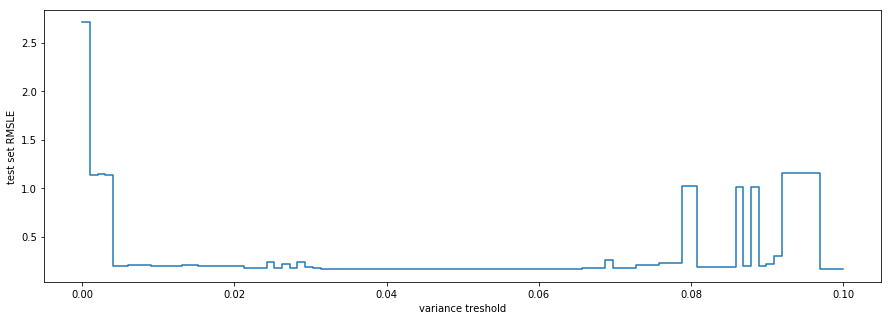

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))
plt.step(test_errs.index, test_errs)
axes.set(xlabel='variance treshold', ylabel='test set RMSLE')

Now let's take a look on RMSLE on validation set:

In [29]:
columns_to_remove = list(dt.columns[dt.var() < best_treshold])
verr, terr = linreg(dt.drop(columns=columns_to_remove), dv.drop(columns=columns_to_remove), verbose=True, msle=my_msle)

LinReg RMSLE valid: 0.16230454775049305
LinReg RMSLE train: 0.13418036047830748


RMSLE on validation set is a bit lower than without feature removal. I would not call this a victory.

## Recursive feature elimination

Now let's take a look on a recursive feature elimination and cross-validated selection of the best number of features

In [30]:
from sklearn.feature_selection import RFECV
from sklearn import metrics

# Prepare the data
X = dt.drop(columns = ['SalePrice'])
print(X.shape)
y = dt.SalePrice

used_columns = X.columns

# define the scorer which will be the RMSE
def scorer(Y, yp):
    return np.sqrt(my_msle(yp, Y))

# prepare the model
clfM = LinearRegression()

# prepare the backward selection algorithm (recursive feature elimination with cross validation)
selector = RFECV(clfM, step=1, cv=5, scoring=metrics.make_scorer(scorer, greater_is_better=False), n_jobs=-1)
# run it
selector = selector.fit(X, y)

(1095, 328)


Let's plot the cross validation score (it needs to be opposite to RMSLE, since this method takes the largest score as best)

Optimal number of features : 52


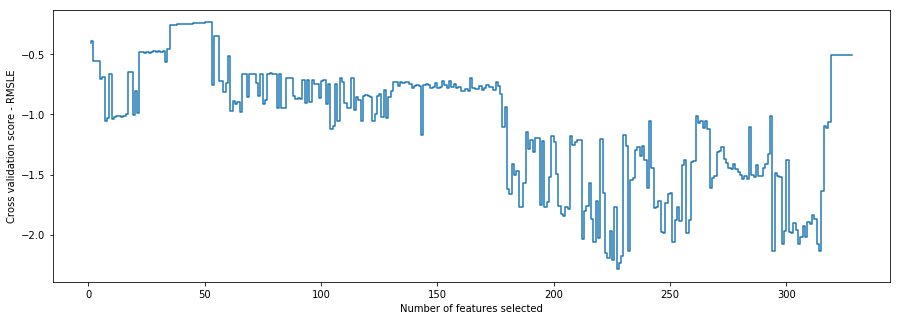

In [31]:
print("Optimal number of features : %d" % selector.n_features_)
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score - RMSLE")
plt.step(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [32]:
# transform result to dataframe
result = pd.DataFrame({'Chosen': selector.support_, 'Ranking': selector.ranking_}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result[result.Chosen == False].head(5))
print('Chosen', len(columns_to_leave),'from ', result.Chosen.shape[0], 'features.')

Chosen  Ranking
MSSubClass    False      270
LotFrontage   False      267
LotArea       False      272
OverallQual   False      231
OverallCond   False      235

Chosen 52 from  328 features.


In [33]:
linreg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']], msle=my_msle)

LinReg RMSLE valid: 0.24479930358796229
LinReg RMSLE train: 0.24441298289321947


(0.24479930358796229, 0.24441298289321947)

This does not look well. RMSLE is too big.

# PCA
First, let's check again, what is RMSLE without PCA.

In [34]:
linreg(dt, dv)

LinReg RMSLE valid: 0.167357599945378
LinReg RMSLE train: 0.09821406780159678


(0.167357599945378, 0.09821406780159678)

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

Standardization is needed for PCA, since it needs to have its input variables centered. Therefore I use scaled data.

In [36]:
pca = PCA()

dfp = pd.DataFrame(pca.fit_transform(dt_s.drop(['SalePrice'], axis=1), dt_s.SalePrice))
explained_variance = pca.explained_variance_ratio_

A scree plot visualizes the dimensionality of the data.

The scree plot shows the cumulative variance explained by each principal component. You can make decision on the number of components to keep to adequately describe a dataset using ad-hoc rules such as components with a variance > 0.7 or where the cumulative proportion of variation is > 80% or > 90% [\[link\]](https://analyse-it.com/docs/user-guide/multivariate/scree-plot)

Cumulative plot is cumulative explained variance ratio as a function of the number of components.

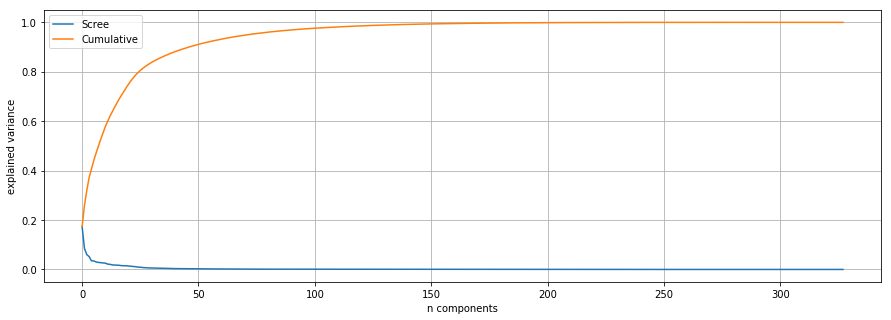

In [37]:
PCs = ['PC-' + str(i) for i in range(1, len(explained_variance) + 1)]
test_df = pd.DataFrame({'var':explained_variance,'PC':PCs})

fig, axes = plt.subplots(1, 1, figsize=(15,5))
plt.grid()
plt.plot(range(0, len(explained_variance)), explained_variance, label='Scree')
plt.plot(range(0, len(explained_variance)), explained_variance.cumsum(), label='Cumulative')
axes.set(xlabel='n components', ylabel='explained variance')
plt.legend()

In general, there is known approach for choosing the right number of components - on scree's elbow. This number of components is rather small (around 10) so it would not explain our dataset well. Therefore I will choose by cumulative curve.

First 100-150 components are explaining most of the data, which can be plausible for prediction.

In [38]:
display(sum(explained_variance[:125]))

0.9872538429852629

In [39]:
def pca_pipeline(n_components, train, test):
    pca = PCA(n_components)
    pca.fit(train.drop(['SalePrice'], axis=1), train.SalePrice)

    PCs = ['PC' + str(i) for i in range(1, n_components + 1)]
    train_pcs = pd.DataFrame(data=pca.transform(train.drop(['SalePrice'], axis=1)), columns=PCs)
    test_pcs = pd.DataFrame(data=pca.transform(test.drop(['SalePrice'], axis=1)), columns=PCs)

    train.index = range(0, train.shape[0])
    test.index = range(0, test.shape[0])

    train_pca_final = pd.concat([train_pcs, train.SalePrice], axis=1)
    test_pca_final = pd.concat([test_pcs, test.SalePrice], axis=1)
    return train_pca_final, test_pca_final

In [40]:
linreg(*pca_pipeline(125, dt_s, dv_s), msle=my_msle)

LinReg RMSLE valid: 0.15777710460818511
LinReg RMSLE train: 0.14498457324514946


(0.15777710460818511, 0.14498457324514946)

This looks good. RMSLE is a bit smaller than without applying PCA.

In [41]:
components = list(range(1, 250))
test_errs = pd.Series(index=components)
test_errs_ns = pd.Series(index=components)
for n_components in components:
    # split train set into train & test again, so that validation is unknown.
    dtr, dts = train_test_split(dt_s, test_size=0.10, random_state=17)
    dtr_ns, dts_ns = train_test_split(dt, test_size=0.10, random_state=17)
    
    test_errs[n_components] = linreg(*pca_pipeline(n_components, dtr, dts), verbose=False, msle=my_msle)[0]
    test_errs_ns[n_components] = linreg(*pca_pipeline(n_components, dtr_ns, dts_ns), verbose=False, msle=my_msle)[0]

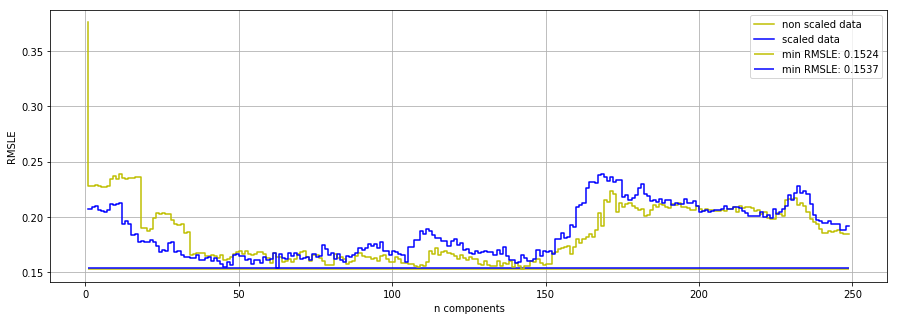

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))
plt.grid()
plt.step(x=test_errs_ns.index, y=test_errs_ns, c='y', label='non scaled data')
plt.hlines(y=test_errs_ns.min(), xmin=test_errs_ns.index[0], xmax=len(test_errs_ns), colors='y', linestyles='solid', label=f"min RMSLE: {test_errs_ns.min():0.4f}")

plt.step(x=test_errs.index, y=test_errs, c='b', label='scaled data')
plt.hlines(y=test_errs.min(), xmin=test_errs.index[0], xmax=len(test_errs), colors='b', linestyles='solid', label=f"min RMSLE: {test_errs.min():0.4f}")
axes.set(xlabel='n components', ylabel='RMSLE')
plt.legend()

In this plot we can see, how high is RMSLE on test subset. 

In [43]:
print("n components without scaling:", test_errs_ns.idxmin())
print("n components with scaling:", test_errs.idxmin())

n components without scaling: 143
n components with scaling: 63


OK, so I am not going to use the *n components without scaling*, since this is generally a bad approach. 

I will use 46 as number of components, 

In [44]:
linreg(*pca_pipeline(46, dt_s, dv_s), msle=my_msle)

LinReg RMSLE valid: 0.1434723773171236
LinReg RMSLE train: 0.1751462673811973


(0.1434723773171236, 0.1751462673811973)

This is not bad. Without PCA I was able to obtain `RMSLE=0.167` and after PCA I have `RMSLE=0.144`. It's not much, but I hope it's an honest work.

# Conclusion

* Split the dataset into a train & test part exactly as we did in the tutorial. Use the test part for evaluation of the influence of further steps.

    * I split the dataset into train & validation set and for each approach of preprocessing I split the train set into train & test dataset. I used the validation par for evaluation of the influence of steps.

* Transform features appropriately & prepare new ones - focus on the increase in the performance of the model (possibly in combination with further steps).

    * I scaled the continous data with StandardScaler, and let the dummies be unchanged.

* Try to find some suitable subset of features - first without the use of PCA.
   
   * I tried to find subset of features by variance treshold and then with recursive feature elimination and cross-validated selection of the best number of features. Both of them gave not-so-satisfiable results.

* Use PCA (principal component analysis) to reduce the dimensionality. Discuss the influence of the number of principal components.

    * I used PCA on scaled an unscaled train & test subset of samples. I showed the influence of the number of principal components on a plot.

* Compare the results of previous steps on the test part of the dataset.

    * Everytime I tried to evaluate each approach, I revealed the RMSLE on validation subset.
   
PCA looks like a strong tool to reduce dimensionality. One must be careful, how much components to take and rather look at the results analytically.